<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/tplstm_classificationinstantannee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP LSTM

la liste des paquets nécessaires au programme


In [0]:
from __future__ import print_function
import os
import sys

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.autograd.variable

from matplotlib import pyplot as plt

définition d'un générateur aléatoire de signaux :  
* classe 0 -> rampe décroissante
* classe 1 -> constante
* classe 2 -> rampe croissante

auquel on ajoute un bruit uniforme de grande intensité

**l'objectif est d'être capable de prédire en chaque point s'il fait parti de la classe 0, 1 ou 2 (sachant qu'il y a des ambiguités à cause du bruit)**

In [0]:
N = 5
T = 400
def generateSample():
    #generating gt and corresponding
    y = np.zeros((T,N),dtype=int)
    signal = np.zeros((T,N,1),dtype=int)
    for n in range(N):
        t=1
        while t<T:
            Dt = random.randint(10,40)
            classe = random.randint(0,2)
            while y[t-1][n]==classe and classe!=1:
                classe = random.randint(0,2)    
            for dt in range(Dt):
                if t+dt<T:
                    y[t+dt][n] = classe
                    signal[t+dt][n][0] = (dt+1)*(classe-1)
            t+=Dt
    
    #generating pure noise          
    x = np.random.randint(-6,7,size=(T,N,1))

    #adding the signal
    x += signal
    x = np.maximum(x,np.ones((T,N,1),dtype=int)*(-20))
    x = np.minimum(x,np.ones((T,N,1),dtype=int)*19)
    x += 20
    
    return x,y


fonction de visualisation des signaux - de la classe et de la prédiction 
* vert pour la classe 0
* bleu pour la classe 1
* rose pour la classe 2

In [0]:
def visualizecurve(x,y,z):
    grid = np.ones((40*N,T,3),dtype=int)*255

    for n in range(N):
        for t in range(T):
            if y[t][n]==0:
                grid[40*n:40*n+20,t,:] = np.asarray([207,236,207])
            if y[t][n]==1:
                grid[40*n:40*n+20,t,:] = np.asarray([204,236,239])
            if y[t][n]==2:
                grid[40*n:40*n+20,t,:] = np.asarray([221,212,232])
                
            if z[t][n]==0:
                grid[40*n+20:40*n+40,t,:] = np.asarray([207,236,207])
            if z[t][n]==1:
                grid[40*n+20:40*n+40,t,:] = np.asarray([204,236,239])
            if z[t][n]==2:
                grid[40*n+20:40*n+40,t,:] = np.asarray([221,212,232])
            
            grid[40*n+x[t][n]][t] = np.zeros(3,dtype=int)
            
    return np.uint8(grid)

définition du réseau - actuellement un réseau récurrent naif - à convertir en lstm 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.output3 = nn.Linear(1, 3, bias=True)

    def forward(self, x):
        T,N,_ = x.shape
        

        alloutput = []
        for t in range(T):
            vx = torch.autograd.Variable(torch.Tensor(x[t]).float()) # linear expect Nx1 input
            
            output = self.output3(vx)
            alloutput.append(output)
            
        return alloutput

    def forwardnp(self,x):
        T,N,_ = x.shape
        
        alloutput = self.forward(x)
        
        npprob = np.zeros((T,N,3),dtype=float)
        for t in range(T): 
            npprob[t] = alloutput[t].cpu().data.numpy()
        
        pred = np.argmax(npprob,axis=2)
        return pred,npprob

model = Net()
model.train()



Net(
  (output3): Linear(in_features=1, out_features=3, bias=True)
)

l'apprentissage et les paramètres associés

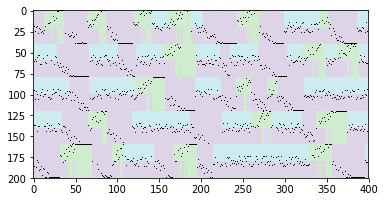

error= 1290 	optimisation loss= 3809.3682
error= 980 	optimisation loss= 623.35364
error= 1247 	optimisation loss= 407.85306
error= 1561 	optimisation loss= 395.3395
error= 1350 	optimisation loss= 407.22083
error= 1281 	optimisation loss= 402.19058
error= 1574 	optimisation loss= 390.3934
error= 1648 	optimisation loss= 399.48343
error= 1003 	optimisation loss= 390.63202
error= 1296 	optimisation loss= 390.53195
error= 1628 	optimisation loss= 391.9392
error= 1385 	optimisation loss= 410.14136
error= 1439 	optimisation loss= 387.7621
error= 1397 	optimisation loss= 385.887
error= 1157 	optimisation loss= 390.65826
error= 1300 	optimisation loss= 400.99942
error= 1568 	optimisation loss= 382.06653
error= 1177 	optimisation loss= 391.4593
error= 1546 	optimisation loss= 383.62762
error= 1562 	optimisation loss= 388.67056
error= 1327 	optimisation loss= 382.8406
error= 1138 	optimisation loss= 376.59418
error= 1124 	optimisation loss= 373.66187


KeyboardInterrupt: ignored

In [0]:
lr = 0.00001
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
losslayer = nn.CrossEntropyLoss()

from IPython.display import clear_output # command to clear the figures
from time import sleep

allprints = []
nbepoch = 200
for epoch in range(nbepoch):
    x,y=generateSample()
    
    alloutput = model(x)

    npprob = np.zeros((T,N,3),dtype=float)
    for t in range(T): 
        npprob[t] = alloutput[t].cpu().data.numpy()
    z = np.argmax(npprob,axis=2)

    allloss = []
    for t in range(T):
        targett = torch.autograd.Variable(torch.from_numpy(y[t]).long())
        losst = losslayer(alloutput[t], targett)
        allloss.append(losst)

    loss = sum(allloss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%8==0:
        #show how it learn
        nberror = (np.transpose(np.nonzero(y-z))).shape[0]
        allprints.append(("error=",nberror,"\toptimisation loss=", loss.cpu().data.numpy()))
        visu = visualizecurve(x[:,:,0],y,z)
        clear_output()
        plt.imshow(visu)
        plt.show()
        for a,b,c,d in allprints:
            print(a,b,c,d)
        sleep(1)
 
